# Automatic Fs low values reduction calculator
This script automatically calculates the config parameter `min_value_for_not_reduce` for Fs small values reduction (for noisy Fs). It was written both for research (prior to writing production code) and for POCs (running versions of the product without automatic Fs low values reduction calculation in the production code).

### Assumptions:
This script assumes that there's an accessible mongo with the collections starting with `scored___aggr_event` populated. These are used in order to find which Fs are noisy (such that low values reduction can help reducing the noise).

### Configuration:
* `mongo_ip` should be configured with the right ip.
* `verbose` can be set to `True` in order to print more stuff.
* `show_graphs` should be set to `True` only when you want to display graphs (typically in research environment).
* `aggregated_feature_event_prevalance_stats_path` is the path to the version of the configuration installed for the customer. The reason this is needed is so we can undo the reduction done in runtime - so we can see the real values and scores and decide on the right new reduction (which might be different than what we've set during the installation process).

### Output:
The names of the Fs that should be reduced are printed following by a number - this is the `min_value_for_not_reduce` parameter. All the other parameters (`max_value_for_fully_reduce` and `reducing_factor`) should be set manually.

In [2]:
import time
import datetime
import sys
sys.path.append('..')
from utils import print_verbose
from algorithm.fs_reduction import calc_min_value_for_not_reduce_for_hists, score_to_weight_squared_min_50, score_to_weight_linear
from data.fs import Fs
import config
if config.show_graphs:
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
%load_ext autoreload
%autoreload 2

In [15]:
%%javascript
IPython.load_extensions('usability\\execute_time\\ExecuteTime');

<IPython.core.display.Javascript object>

In [5]:
start_time = time.time()

In [6]:
fs = globals().get('fs') or Fs('fs.txt')

08:59:44: lodaing...
09:00:00: loaded 100000 users
09:00:11: loaded 200000 users
09:11:08: finished loading
09:11:08: Queried collections:
	scored___aggr_event__distinct_number_of_src_machines_vpn_daily
	scored___aggr_event__number_of_successful_kerberos_logins_hourly
	scored___aggr_event__distinct_number_of_src_machines_kerberos_logins_hourly
	scored___aggr_event__number_of_successful_kerberos_logins_daily
	scored___aggr_event__distinct_number_of_dst_machines_kerberos_logins_hourly
	scored___aggr_event__distinct_number_of_dst_machines_ssh_daily
	scored___aggr_event__number_of_failed_ssh_events_hourly
	scored___aggr_event__distinct_number_of_dst_machines_kerberos_logins_daily
	scored___aggr_event__number_of_failed_kerberos_logins_daily
	scored___aggr_event__distinct_number_of_src_machines_ssh_hourly
	scored___aggr_event__distinct_number_of_countries_vpn_daily
	scored___aggr_event__number_of_failed_vpn_daily
	scored___aggr_event__number_of_successful_ssh_daily
	scored___aggr_event__dist


----------------------------------------------------------------------
--------------------- min_value_for_not_reduce  ----------------------
----------------------------------------------------------------------
09:34:17: empty collection: scored___aggr_event__distinct_number_of_src_machines_vpn_daily

09:34:17: scored___aggr_event__number_of_successful_kerberos_logins_hourly:
09:34:18: median value: 3.0 , max_bad_value_diff: 1
09:34:22: true positives:
09:34:22: Area under histogram: 15501.44
09:34:22: {3.0: 389.7599999999931, 4.0: 442.289999999994, 5.0: 637.9900000000073, 6.0: 896.3400000000128, 7.0: 1065.710000000002, 8.0: 1205.819999999999, 9.0: 1120.5000000000014, 10.0: 1120.110000000005, 11.0: 946.5800000000025, 12.0: 858.620000000002, 13.0: 751.6200000000001, 14.0: 678.4100000000004, 15.0: 557.9400000000009, 16.0: 496.9600000000002, 17.0: 422.34000000000054, 18.0: 363.5200000000004, 19.0: 286.04999999999995, 20.0: 281.3100000000001, 21.0: 251.36000000000013, 22.0: 197.32000000

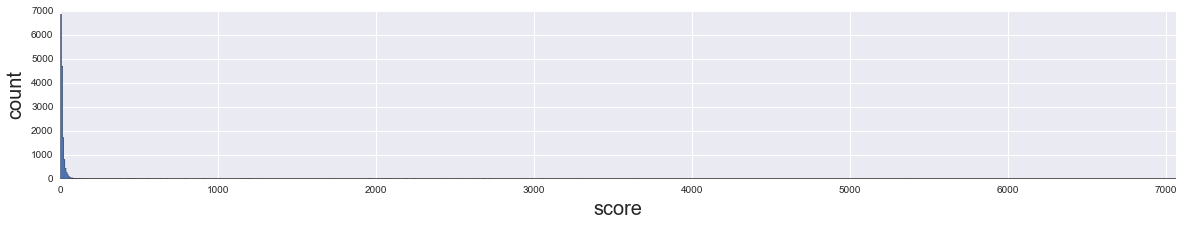

09:34:22: false positives:
09:34:22: Area under histogram: 573.94
09:34:22: {2.0: 515.7499999999956, 3.0: 37.27000000000015, 4.0: 12.56000000000002, 5.0: 4.769999999999998, 6.0: 1.9100000000000013, 7.0: 0.7700000000000002, 8.0: 0.42000000000000004, 9.0: 0.35000000000000003, 10.0: 0.07, 14.0: 0.07}


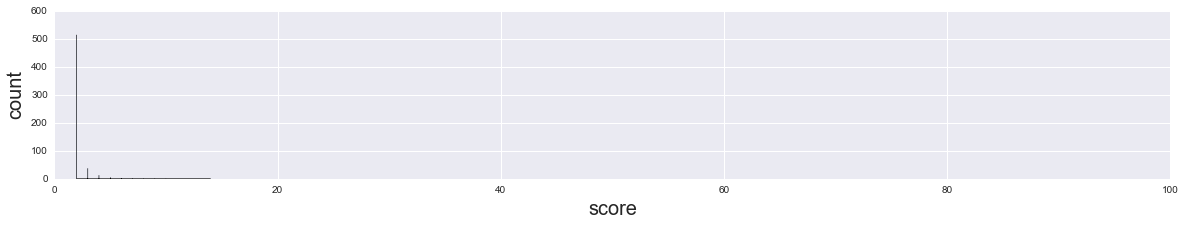

09:34:24: aaa 0.978793629126
09:34:24: found reducer: {'max_value_for_fully_reduce': 4, 'min_value_for_not_reduce': 8, 'reducing_factor': 0.1}

09:34:24: scored___aggr_event__distinct_number_of_src_machines_kerberos_logins_hourly:
09:34:24: median value: 1.0 , max_bad_value_diff: 1
09:34:26: true positives:
09:34:26: Area under histogram: 786.04
09:34:26: {3.0: 285.70000000000016, 4.0: 168.33000000000033, 5.0: 105.71000000000008, 6.0: 54.67999999999999, 7.0: 33.78999999999999, 8.0: 29.079999999999995, 9.0: 11.74, 10.0: 11.559999999999999, 11.0: 12.770000000000001, 12.0: 7.5200000000000005, 13.0: 10.139999999999999, 14.0: 4.53, 15.0: 6.890000000000001, 16.0: 2.46, 17.0: 6.53, 18.0: 2.6, 19.0: 2.02, 20.0: 2.06, 21.0: 4.1000000000000005, 22.0: 1.97, 23.0: 1.0, 24.0: 2.0, 27.0: 0.33, 34.0: 0.8, 36.0: 1.0, 42.0: 0.77, 43.0: 3.88, 44.0: 1.75, 45.0: 1.87, 46.0: 0.91, 47.0: 2.98, 51.0: 1.0, 54.0: 1.0, 56.0: 1.0, 58.0: 1.0, 195.0: 0.5700000000000001}


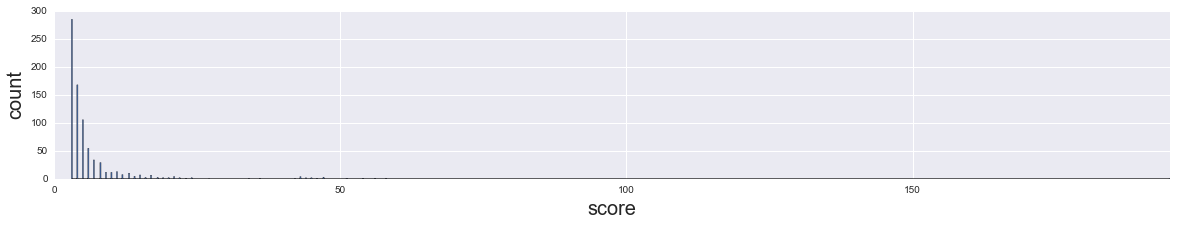

09:34:26: false positives:
09:34:26: Area under histogram: 932.81
09:34:26: {2.0: 932.7900000000127, 3.0: 0.02}


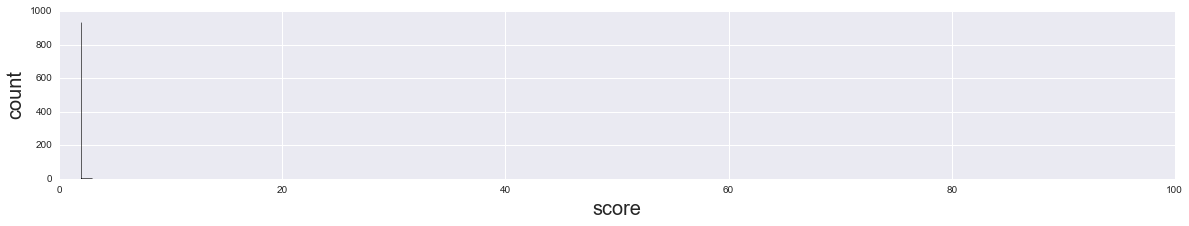

09:34:26: aaa 0.83622881457
09:34:26: found reducer: {'max_value_for_fully_reduce': 2, 'min_value_for_not_reduce': 3, 'reducing_factor': 0.1}

09:34:26: scored___aggr_event__number_of_successful_kerberos_logins_daily:
09:34:26: median value: 12.0 , max_bad_value_diff: 2
09:34:27: true positives:
09:34:27: Area under histogram: 5403.05
09:34:27: {513.0: 0.65, 4.0: 90.79000000000043, 5.0: 100.15000000000055, 6.0: 107.17000000000053, 7.0: 111.12000000000064, 8.0: 106.68000000000032, 9.0: 119.41000000000038, 10.0: 119.90000000000045, 11.0: 119.74000000000056, 12.0: 120.90000000000059, 13.0: 125.83000000000058, 14.0: 145.78999999999996, 15.0: 136.87000000000023, 16.0: 149.83999999999995, 17.0: 144.61999999999995, 18.0: 139.1000000000002, 19.0: 138.64000000000004, 20.0: 132.52000000000012, 21.0: 126.9000000000004, 22.0: 134.46000000000015, 23.0: 123.12000000000019, 24.0: 132.48000000000005, 25.0: 111.21000000000002, 26.0: 112.68000000000004, 27.0: 113.87999999999995, 28.0: 99.44000000000004,

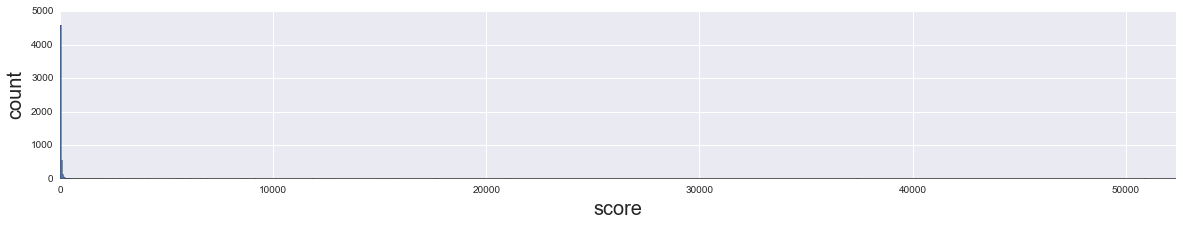

09:34:27: false positives:
09:34:27: Area under histogram: 343.98
09:34:27: {2.0: 140.10000000000036, 3.0: 135.08000000000055, 4.0: 33.899999999999956, 5.0: 11.899999999999991, 6.0: 7.700000000000004, 7.0: 4.800000000000002, 8.0: 3.0, 9.0: 2.8000000000000003, 10.0: 1.5, 11.0: 0.8, 12.0: 0.4, 13.0: 0.8, 14.0: 0.4, 15.0: 0.6000000000000001, 16.0: 0.2}


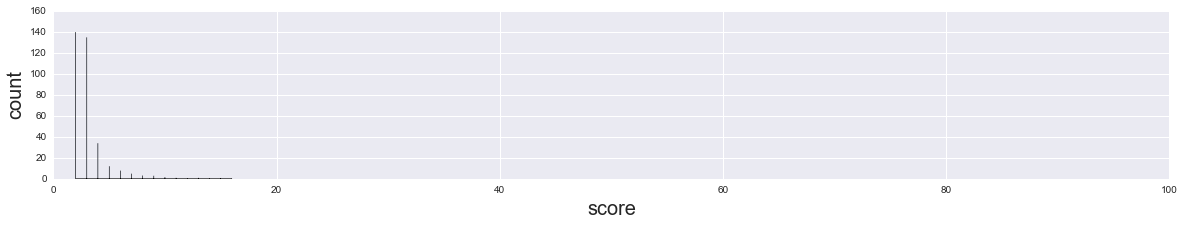

09:34:29: aaa 0.964008919654
09:34:29: found reducer: {'max_value_for_fully_reduce': 9, 'min_value_for_not_reduce': 15, 'reducing_factor': 0.1}

09:34:29: scored___aggr_event__distinct_number_of_dst_machines_kerberos_logins_hourly:
09:34:30: median value: 2.0 , max_bad_value_diff: 1
09:34:33: true positives:
09:34:33: Area under histogram: 6237.93
09:34:33: {3.0: 257.6400000000087, 4.0: 636.1799999999893, 5.0: 1106.519999999983, 6.0: 1160.0300000000038, 7.0: 986.2500000000007, 8.0: 814.8400000000014, 9.0: 489.0600000000007, 10.0: 244.49999999999997, 11.0: 155.68999999999997, 12.0: 89.68999999999998, 13.0: 55.89999999999999, 14.0: 35.25999999999999, 15.0: 20.38, 16.0: 18.35, 17.0: 19.699999999999996, 18.0: 10.94, 19.0: 13.0, 20.0: 10.289999999999997, 21.0: 8.7, 22.0: 6.44, 23.0: 5.739999999999999, 24.0: 2.9699999999999998, 25.0: 3.15, 26.0: 7.9799999999999995, 27.0: 4.470000000000001, 28.0: 4.65, 29.0: 1.77, 30.0: 3.67, 31.0: 2.08, 32.0: 2.66, 33.0: 3.34, 34.0: 1.29, 35.0: 2.74, 36.0: 1

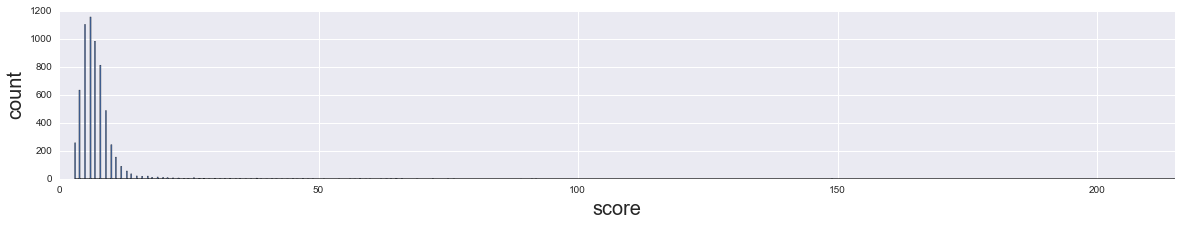

09:34:34: false positives:
09:34:34: Area under histogram: 173.4
09:34:34: {2.0: 134.34000000001302, 3.0: 29.59999999999982, 4.0: 7.9, 5.0: 1.5600000000000007}


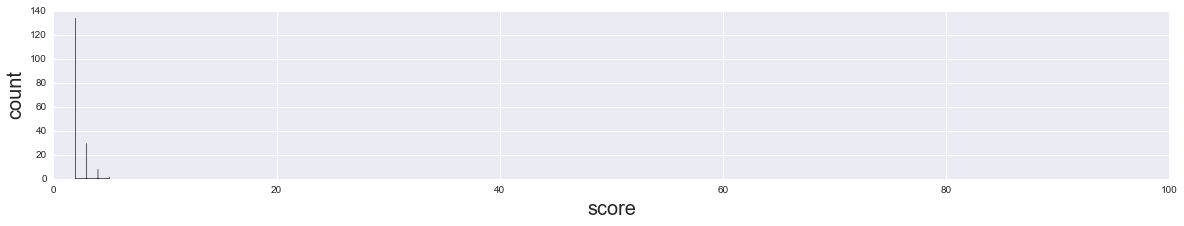

09:34:34: aaa 0.97280239788

09:34:34: scored___aggr_event__distinct_number_of_dst_machines_ssh_daily:
09:34:34: median value: 1.0 , max_bad_value_diff: 1
09:34:34: true positives:
09:34:34: Area under histogram: 1195.62
09:34:34: {3.0: 122.69999999999858, 4.0: 152.26000000000053, 5.0: 165.3699999999995, 6.0: 145.0000000000001, 7.0: 110.88000000000005, 8.0: 90.00000000000006, 9.0: 65.30000000000004, 10.0: 43.57, 11.0: 30.38999999999999, 12.0: 33.62, 13.0: 26.639999999999993, 14.0: 23.930000000000003, 15.0: 7.01, 16.0: 14.069999999999999, 17.0: 8.05, 18.0: 16.839999999999996, 19.0: 17.31, 20.0: 8.3, 21.0: 5.39, 22.0: 2.49, 23.0: 2.99, 24.0: 4.52, 25.0: 1.78, 26.0: 1.2, 27.0: 5.570000000000001, 28.0: 7.2299999999999995, 29.0: 4.99, 30.0: 6.49, 31.0: 4.2, 32.0: 1.4100000000000001, 33.0: 2.42, 34.0: 3.2300000000000004, 35.0: 2.4699999999999998, 36.0: 4.11, 37.0: 2.7800000000000002, 38.0: 2.01, 39.0: 1.07, 40.0: 2.26, 42.0: 0.99, 43.0: 2.18, 44.0: 0.99, 45.0: 0.86, 46.0: 1.26, 47.0: 1.32, 1

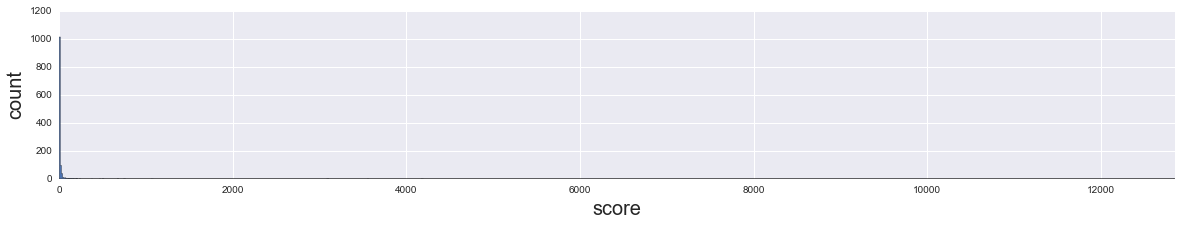

09:34:34: false positives:
09:34:34: Area under histogram: 195.14
09:34:34: {2.0: 135.4399999999998, 3.0: 30.660000000000043, 4.0: 8.080000000000004, 5.0: 4.960000000000002, 6.0: 2.5000000000000004, 7.0: 1.5999999999999999, 8.0: 0.2, 10.0: 0.7, 11.0: 0.5, 12.0: 0.3, 15.0: 0.2, 16.0: 1.0, 19.0: 7.699999999999999, 20.0: 0.6, 25.0: 0.2, 62.0: 0.3, 52.0: 0.2}


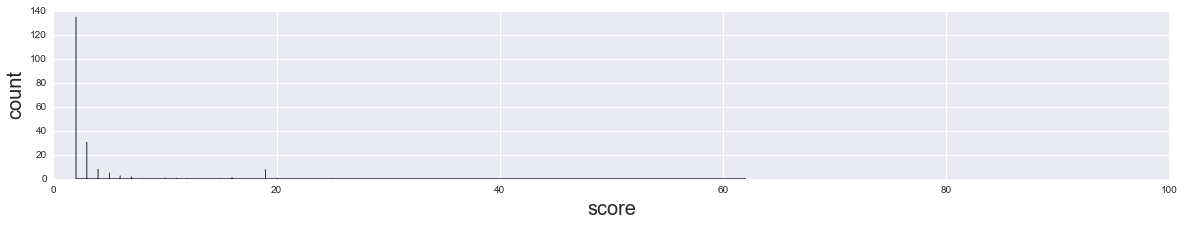

09:34:35: aaa 0.901892141106
09:34:35: found reducer: {'max_value_for_fully_reduce': 3, 'min_value_for_not_reduce': 6, 'reducing_factor': 0.1}

09:34:35: scored___aggr_event__number_of_failed_ssh_events_hourly:
09:34:36: median value: 0.0 , max_bad_value_diff: 1
09:34:41: true positives:
09:34:41: Area under histogram: 25644.09
09:34:41: {2.0: 2828.1799999999967, 3.0: 1335.800000000003, 4.0: 802.7500000000022, 5.0: 477.5200000000002, 6.0: 458.45999999999987, 7.0: 268.03000000000003, 8.0: 351.2299999999998, 9.0: 261.79999999999995, 10.0: 302.1099999999999, 11.0: 179.17999999999995, 12.0: 219.72000000000003, 13.0: 128.26, 14.0: 160.32000000000002, 15.0: 143.31, 16.0: 328.3400000000001, 17.0: 892.8100000000007, 18.0: 1537.3000000000018, 19.0: 1483.940000000002, 20.0: 4186.799999999986, 21.0: 5669.599999999962, 22.0: 2513.8599999999974, 23.0: 29.209999999999997, 24.0: 23.21, 25.0: 23.01, 26.0: 21.739999999999995, 27.0: 15.47, 28.0: 15.379999999999999, 29.0: 19.319999999999997, 30.0: 23.380

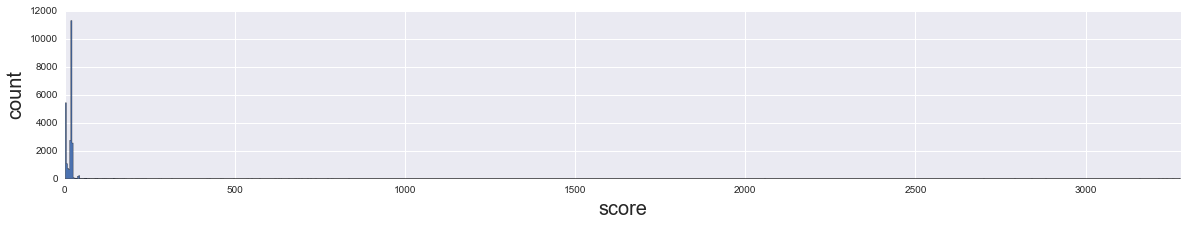

09:34:41: false positives:
09:34:41: Area under histogram: 6654.14
09:34:41: {1.0: 6464.209999999949, 2.0: 131.3399999999987, 3.0: 30.620000000000015, 4.0: 9.559999999999999, 5.0: 7.799999999999999, 6.0: 0.07, 7.0: 0.42000000000000004, 16.0: 0.47000000000000003, 17.0: 0.6000000000000001, 18.0: 0.17, 19.0: 0.6300000000000001, 20.0: 0.42000000000000004, 21.0: 0.41000000000000003, 22.0: 4.47, 31.0: 2.95}


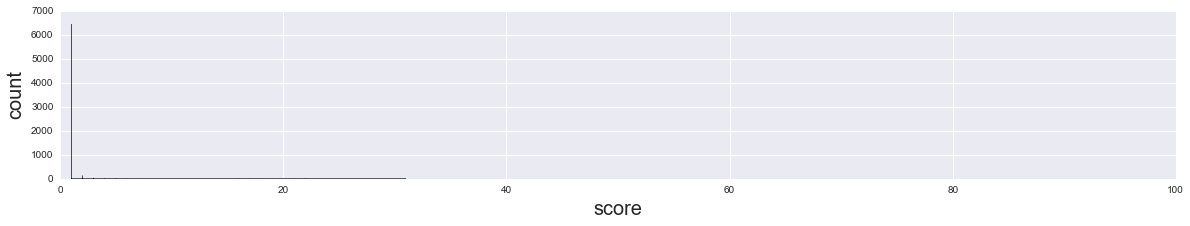

09:34:42: aaa 0.957582505764
09:34:42: found reducer: {'max_value_for_fully_reduce': 2, 'min_value_for_not_reduce': 4, 'reducing_factor': 0.1}

09:34:42: scored___aggr_event__distinct_number_of_dst_machines_kerberos_logins_daily:
09:34:42: median value: 4.0 , max_bad_value_diff: 2
09:34:43: true positives:
09:34:43: Area under histogram: 2220.7
09:34:43: {4.0: 150.8900000000012, 5.0: 223.69999999999638, 6.0: 277.20999999999754, 7.0: 266.9899999999982, 8.0: 227.1199999999994, 9.0: 215.17999999999884, 10.0: 184.81999999999954, 11.0: 129.37000000000012, 12.0: 105.86, 13.0: 62.63999999999999, 14.0: 69.19000000000003, 15.0: 50.240000000000016, 16.0: 33.27000000000001, 17.0: 26.349999999999994, 18.0: 20.94, 19.0: 15.979999999999997, 20.0: 14.339999999999996, 21.0: 13.839999999999998, 22.0: 14.950000000000001, 23.0: 8.16, 24.0: 10.689999999999998, 25.0: 10.640000000000002, 26.0: 8.930000000000001, 27.0: 5.38, 28.0: 9.14, 29.0: 6.17, 30.0: 4.87, 31.0: 3.13, 32.0: 5.0, 33.0: 4.2, 34.0: 2.69, 35

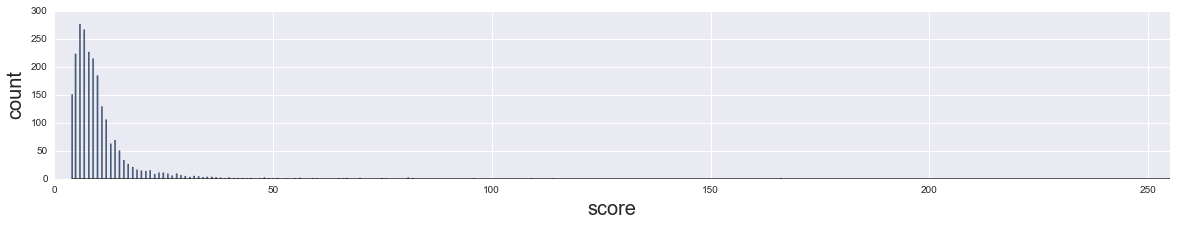

09:34:43: false positives:
09:34:43: Area under histogram: 579.63
09:34:43: {2.0: 39.160000000000494, 3.0: 186.14999999999034, 4.0: 143.68000000000086, 5.0: 105.68999999999919, 6.0: 62.05000000000022, 7.0: 20.199999999999985, 8.0: 10.099999999999998, 9.0: 4.4, 10.0: 3.800000000000001, 11.0: 3.3000000000000007, 12.0: 0.2, 13.0: 0.4, 110.0: 0.3, 15.0: 0.2}


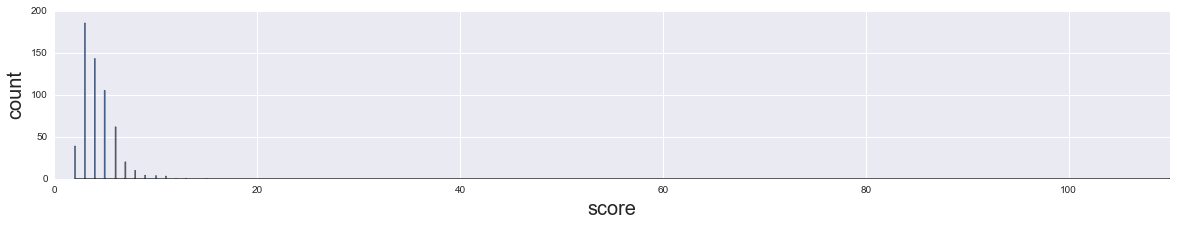

09:34:43: aaa 0.904410100557
09:34:43: found reducer: {'max_value_for_fully_reduce': 7, 'min_value_for_not_reduce': 9, 'reducing_factor': 0.1}
09:34:43: empty collection: scored___aggr_event__number_of_failed_kerberos_logins_daily

09:34:43: scored___aggr_event__distinct_number_of_src_machines_ssh_hourly:
09:34:49: median value: 1.0 , max_bad_value_diff: 1
09:35:14: true positives:
09:35:14: Area under histogram: 14941.97
09:35:14: {3.0: 7933.719999999701, 4.0: 5208.510000000283, 5.0: 659.849999999993, 6.0: 213.01000000000002, 7.0: 106.97999999999998, 8.0: 76.49999999999999, 9.0: 63.85, 10.0: 66.38999999999999, 11.0: 60.73000000000003, 12.0: 52.489999999999995, 13.0: 35.86, 14.0: 30.330000000000002, 15.0: 26.520000000000007, 16.0: 43.4, 17.0: 33.260000000000005, 18.0: 30.439999999999994, 19.0: 20.96, 20.0: 16.34, 21.0: 11.07, 22.0: 9.15, 23.0: 4.39, 24.0: 3.75, 25.0: 5.09, 26.0: 8.63, 27.0: 6.6, 28.0: 6.889999999999999, 29.0: 8.049999999999999, 30.0: 9.780000000000001, 31.0: 3.92999999

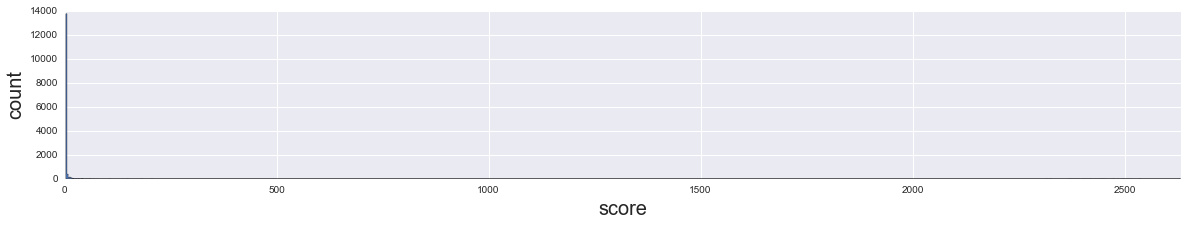

09:35:15: false positives:
09:35:15: Area under histogram: 4275.81
09:35:15: {2.0: 3953.999999999456, 3.0: 197.65000000000165, 4.0: 106.67999999999978, 5.0: 15.879999999999995, 6.0: 1.6}


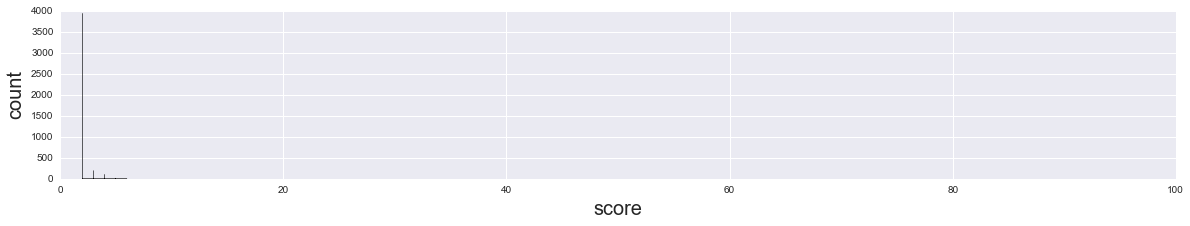

09:35:16: aaa 0.937194373164
09:35:16: found reducer: {'max_value_for_fully_reduce': 2, 'min_value_for_not_reduce': 3, 'reducing_factor': 0.1}

09:35:16: scored___aggr_event__distinct_number_of_countries_vpn_daily:
09:35:16: median value: 1.0 , max_bad_value_diff: 1
09:35:17: true positives:
09:35:17: Area under histogram: 247.78
09:35:17: {3.0: 241.93999999999994, 4.0: 5.840000000000001}


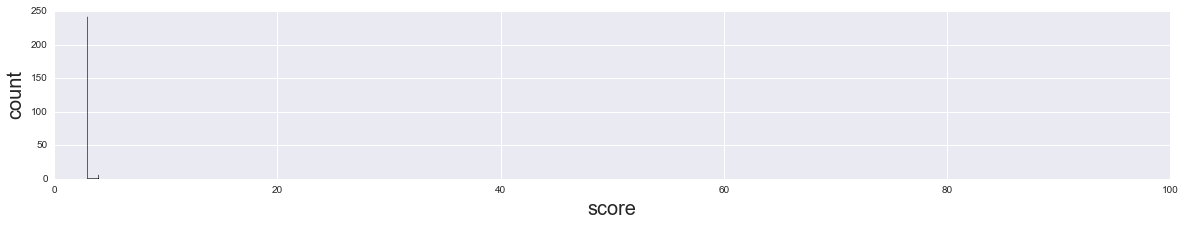

09:35:17: false positives:
09:35:17: Area under histogram: 757.41
09:35:17: {2.0: 756.209999999999, 3.0: 1.2}


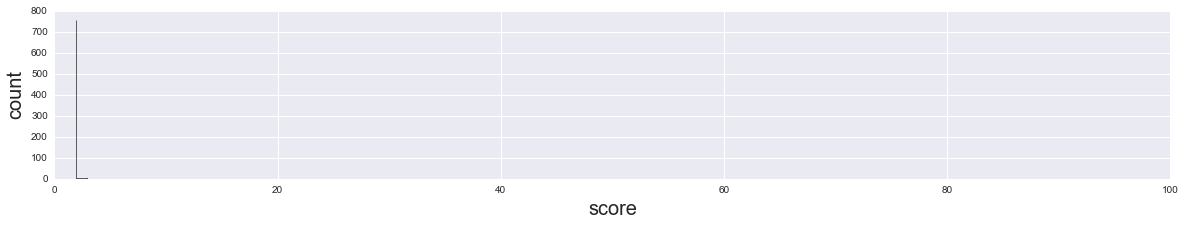

09:35:17: aaa 0.686907919681
09:35:17: found reducer: {'max_value_for_fully_reduce': 2, 'min_value_for_not_reduce': 3, 'reducing_factor': 0.1}

09:35:17: scored___aggr_event__number_of_failed_vpn_daily:
09:35:17: median value: 0.0 , max_bad_value_diff: 1
09:35:17: true positives:
09:35:17: Area under histogram: 1098.98
09:35:17: {2.0: 326.15000000000026, 3.0: 183.36999999999998, 4.0: 125.52000000000007, 5.0: 79.33000000000003, 6.0: 69.03000000000002, 7.0: 46.51, 8.0: 40.26, 9.0: 29.91999999999999, 10.0: 22.79, 11.0: 15.33, 12.0: 21.13, 13.0: 14.73, 14.0: 16.450000000000003, 15.0: 9.990000000000002, 16.0: 14.47, 17.0: 8.34, 18.0: 13.840000000000002, 19.0: 7.7, 20.0: 2.5, 21.0: 2.33, 22.0: 5.68, 23.0: 2.0, 24.0: 2.1, 25.0: 2.49, 26.0: 2.89, 27.0: 1.6, 28.0: 2.7600000000000002, 29.0: 2.88, 30.0: 2.09, 31.0: 1.2, 32.0: 0.3, 33.0: 0.6, 34.0: 4.5, 36.0: 1.0, 37.0: 1.0, 38.0: 0.3, 39.0: 1.0, 40.0: 0.8999999999999999, 412.0: 1.0, 43.0: 1.6600000000000001, 44.0: 0.9, 46.0: 0.6, 51.0: 1.68000000

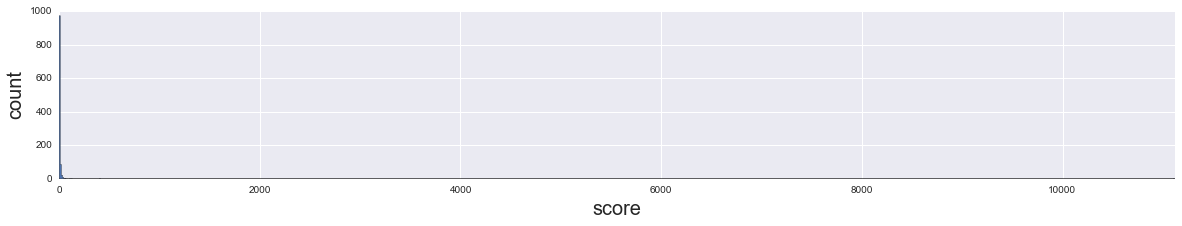

09:35:18: false positives:
09:35:18: Area under histogram: 856.92
09:35:18: {1.0: 802.9799999999988, 2.0: 48.43999999999996, 3.0: 3.5, 4.0: 1.6, 5.0: 0.2, 6.0: 0.2}


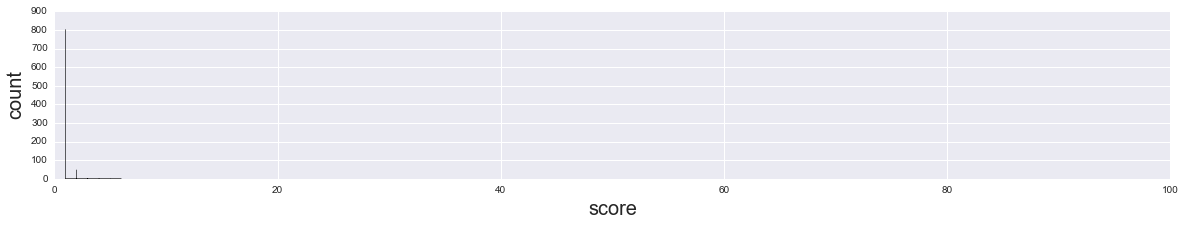

09:35:20: aaa 0.844734456421
09:35:20: found reducer: {'max_value_for_fully_reduce': 2, 'min_value_for_not_reduce': 3, 'reducing_factor': 0.1}

09:35:20: scored___aggr_event__number_of_successful_ssh_daily:
09:35:21: median value: 60.0 , max_bad_value_diff: 2
09:35:22: true positives:
09:35:22: Area under histogram: 9256.68
09:35:22: {3.0: 10.770000000000001, 4.0: 128.29000000000028, 5.0: 126.8800000000002, 6.0: 126.69000000000021, 7.0: 116.15000000000019, 8.0: 117.34000000000015, 9.0: 237.80999999999977, 10.0: 181.38999999999993, 11.0: 171.93000000000004, 12.0: 94.76000000000009, 13.0: 84.34000000000007, 14.0: 78.48999999999998, 15.0: 83.13000000000004, 16.0: 69.81000000000003, 17.0: 85.18000000000004, 18.0: 77.71999999999998, 19.0: 112.97, 20.0: 95.21, 21.0: 79.16000000000001, 22.0: 58.140000000000015, 23.0: 62.180000000000014, 24.0: 156.3199999999999, 25.0: 38.55, 26.0: 50.99000000000001, 27.0: 48.359999999999985, 28.0: 39.67, 29.0: 37.67000000000001, 30.0: 55.94000000000006, 31.0: 

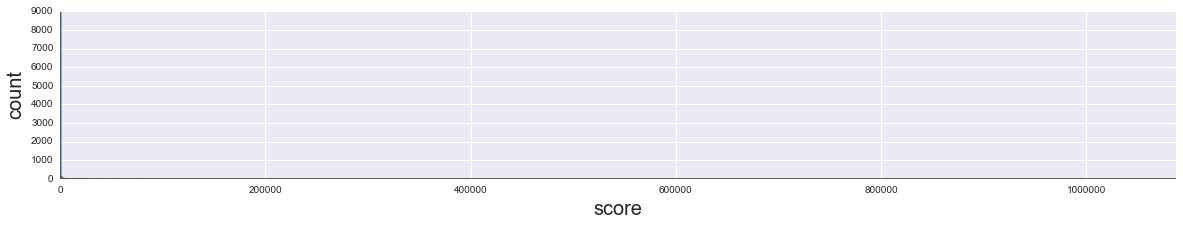

09:35:22: false positives:
09:35:22: Area under histogram: 1166.53
09:35:22: {1.0: 32.479999999999976, 2.0: 585.0099999999973, 3.0: 341.91999999999797, 4.0: 56.57, 5.0: 14.799999999999986, 6.0: 5.600000000000002, 7.0: 9.599999999999998, 8.0: 5.600000000000001, 9.0: 0.9000000000000001, 10.0: 3.1000000000000005, 11.0: 4.0, 12.0: 0.4, 13.0: 0.2, 14.0: 0.8, 15.0: 0.7, 16.0: 0.3, 17.0: 1.4, 18.0: 0.8, 19.0: 1.4, 20.0: 1.2, 21.0: 0.5, 22.0: 0.2, 23.0: 0.5, 24.0: 1.0, 25.0: 1.6, 26.0: 1.7999999999999998, 27.0: 1.5999999999999999, 28.0: 1.9, 29.0: 1.9999999999999998, 30.0: 11.1, 31.0: 28.79999999999999, 32.0: 18.599999999999998, 33.0: 1.2000000000000002, 34.0: 0.4, 35.0: 0.4, 37.0: 4.3, 38.0: 2.0500000000000003, 39.0: 0.6000000000000001, 40.0: 0.6000000000000001, 41.0: 2.1999999999999997, 42.0: 0.4, 44.0: 0.2, 48.0: 0.2, 49.0: 0.9000000000000001, 60.0: 0.4, 62.0: 0.2, 66.0: 0.2, 78.0: 0.4, 79.0: 3.0, 93.0: 0.3, 95.0: 0.2, 97.0: 0.9, 98.0: 0.2, 117.0: 0.2, 119.0: 0.2, 121.0: 0.6000000000000001,

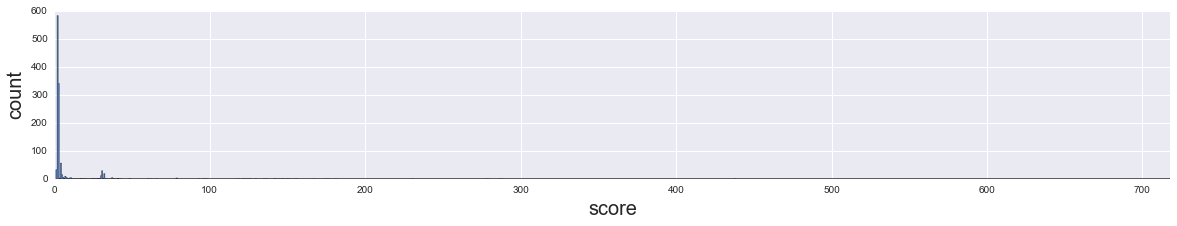

09:35:30: aaa 0.954073827742
09:35:30: found reducer: {'max_value_for_fully_reduce': 7, 'min_value_for_not_reduce': 11, 'reducing_factor': 0.1}
09:35:30: empty collection: scored___aggr_event__distinct_number_of_src_machines_vpn_hourly

09:35:30: scored___aggr_event__number_of_failed_ssh_daily:
09:35:31: median value: 0.0 , max_bad_value_diff: 1
09:35:32: true positives:
09:35:32: Area under histogram: 12024.48
09:35:32: {768.0: 0.97, 2.0: 1365.2800000000038, 3.0: 687.7599999999992, 4.0: 503.32999999999885, 5.0: 289.2, 6.0: 289.8599999999999, 7.0: 126.11999999999999, 8.0: 172.72999999999985, 9.0: 99.55, 10.0: 158.04999999999984, 11.0: 72.25, 12.0: 77.79999999999997, 13.0: 46.709999999999994, 14.0: 64.07999999999998, 15.0: 47.109999999999985, 16.0: 117.57999999999994, 17.0: 429.6499999999997, 18.0: 893.1800000000011, 19.0: 729.050000000001, 20.0: 1862.470000000013, 21.0: 2037.6800000000146, 22.0: 997.9200000000046, 23.0: 11.91, 24.0: 21.660000000000004, 25.0: 5.75, 26.0: 3.2900000000000

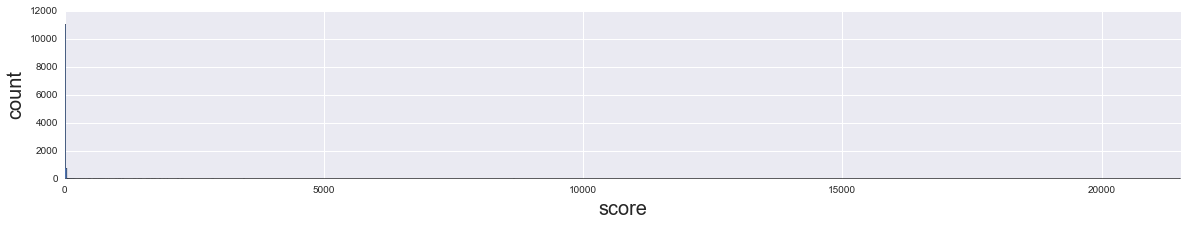

09:35:32: false positives:
09:35:32: Area under histogram: 3285.42
09:35:32: {1.0: 3193.8200000000134, 2.0: 33.699999999999974, 3.0: 16.900000000000002, 4.0: 2.6000000000000005, 5.0: 10.999999999999993, 6.0: 1.0, 7.0: 8.000000000000004, 8.0: 0.5, 9.0: 0.8, 18.0: 0.5, 19.0: 1.7999999999999998, 20.0: 1.2, 21.0: 2.1, 22.0: 11.1, 87.0: 0.2, 25.0: 0.2}


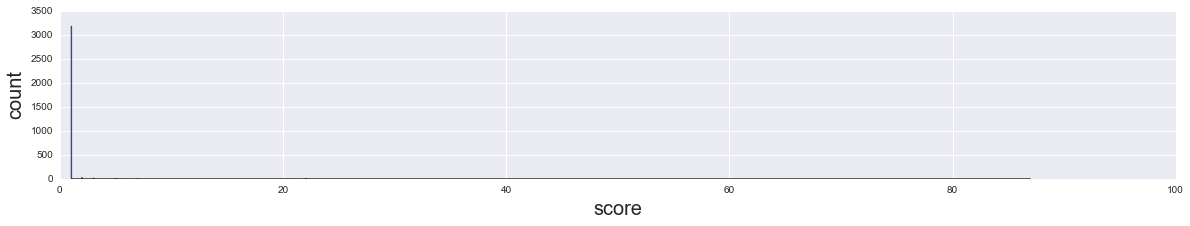

09:35:34: aaa 0.948935968434
09:35:34: found reducer: {'max_value_for_fully_reduce': 1, 'min_value_for_not_reduce': 3, 'reducing_factor': 0.1}

09:35:34: scored___aggr_event__distinct_number_of_src_machines_ssh_daily:
09:36:59: median value: 3.0 , max_bad_value_diff: 1
09:37:22: true positives:
09:37:22: Area under histogram: 4665.03
09:37:22: {3.0: 408.37000000000006, 4.0: 384.35000000000167, 5.0: 2836.8399999998624, 6.0: 565.4999999999898, 135.0: 1.54, 8.0: 76.19999999999995, 9.0: 80.68000000000004, 10.0: 19.919999999999998, 11.0: 10.6, 12.0: 5.22, 13.0: 10.51, 14.0: 10.4, 15.0: 7.88, 16.0: 6.970000000000001, 17.0: 3.1, 18.0: 7.64, 19.0: 11.58, 20.0: 16.6, 21.0: 8.22, 22.0: 4.78, 23.0: 1.0, 24.0: 0.6, 25.0: 1.55, 26.0: 1.0, 27.0: 1.57, 28.0: 1.0, 31.0: 0.46, 32.0: 0.79, 2722.0: 0.87, 37.0: 0.99, 113.0: 0.1, 7.0: 161.23000000000013, 44.0: 2.0, 45.0: 1.03, 46.0: 0.1, 47.0: 1.0, 176.0: 1.0, 177.0: 0.06, 52.0: 0.41000000000000003, 54.0: 0.59, 66.0: 0.99, 69.0: 1.0, 70.0: 1.0, 268.0: 0.19

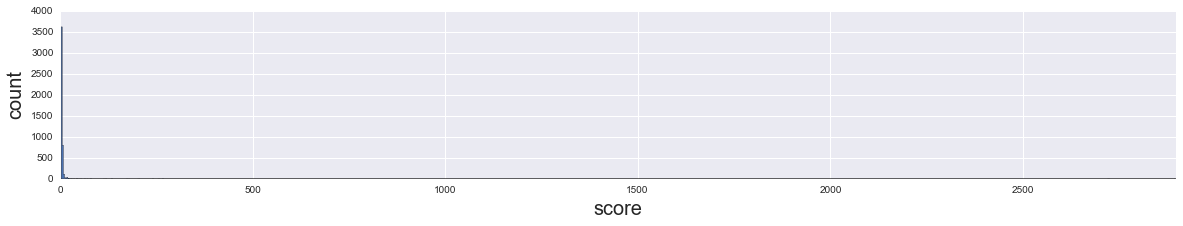

09:37:22: false positives:
09:37:22: Area under histogram: 7806.86
09:37:22: {2.0: 890.1099999998659, 3.0: 365.0399999999962, 4.0: 5940.469999999937, 5.0: 590.1400000000095, 6.0: 20.49999999999999, 7.0: 0.2, 8.0: 0.4}


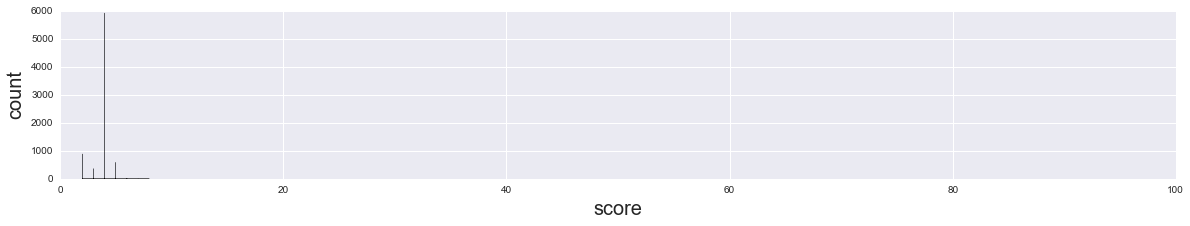

09:37:22: aaa 0.726894006784
09:37:22: found reducer: {'max_value_for_fully_reduce': 4, 'min_value_for_not_reduce': 5, 'reducing_factor': 0.1}

09:37:22: scored___aggr_event__distinct_number_of_src_machines_kerberos_logins_daily:
09:37:34: median value: 1.0 , max_bad_value_diff: 1
09:37:36: true positives:
09:37:36: Area under histogram: 265.46
09:37:36: {3.0: 126.04999999999917, 4.0: 42.819999999999986, 5.0: 18.240000000000002, 6.0: 19.060000000000006, 7.0: 15.26, 8.0: 8.71, 9.0: 5.69, 10.0: 4.82, 11.0: 3.8600000000000003, 12.0: 1.87, 13.0: 2.7199999999999998, 14.0: 1.26, 15.0: 1.38, 16.0: 1.16, 17.0: 1.29, 18.0: 0.5, 19.0: 0.29, 20.0: 0.55, 21.0: 1.03, 22.0: 0.84, 23.0: 1.56, 25.0: 0.5, 27.0: 0.33999999999999997, 29.0: 0.64, 30.0: 0.29, 36.0: 0.18, 38.0: 0.4, 59.0: 0.89, 189.0: 1.0, 66.0: 0.46, 72.0: 0.1, 74.0: 1.0, 217.0: 0.7000000000000001}


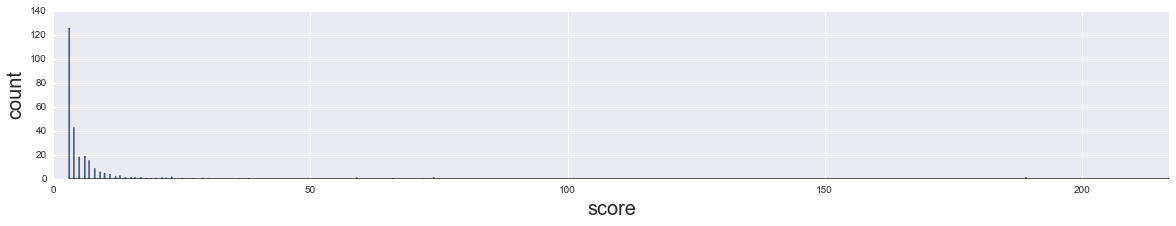

09:37:37: false positives:
09:37:37: Area under histogram: 592.59
09:37:37: {2.0: 588.4099999999747, 3.0: 3.8499999999999988, 4.0: 0.33}


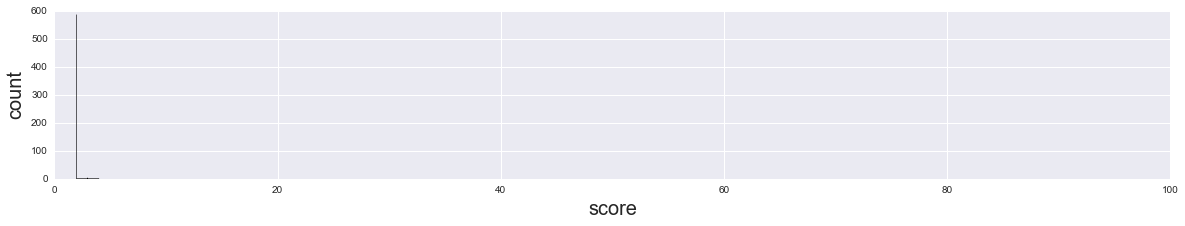

09:37:38: aaa 0.725505649281
09:37:38: found reducer: {'max_value_for_fully_reduce': 2, 'min_value_for_not_reduce': 3, 'reducing_factor': 0.1}
09:37:38: empty collection: scored___aggr_event__number_of_failed_kerberos_logins_hourly

09:37:38: scored___aggr_event__distinct_number_of_countries_vpn_hourly:
09:37:49: median value: 1.0 , max_bad_value_diff: 1
09:37:52: true positives:
09:37:52: Area under histogram: 18.4
09:37:52: {3.0: 18.400000000000002}


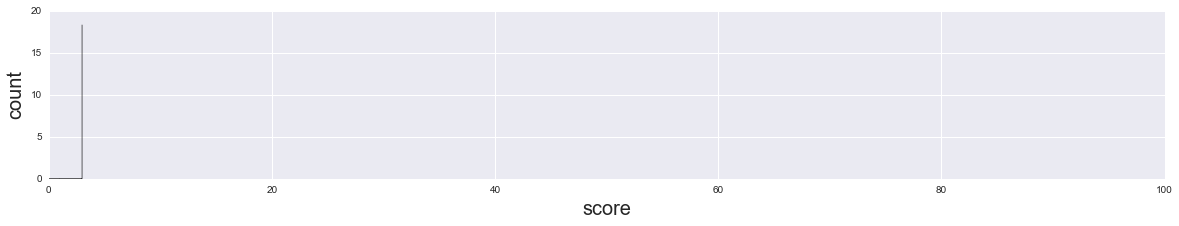

09:37:52: false positives:
09:37:52: Area under histogram: 257.63
09:37:52: {2.0: 257.6299999999975}


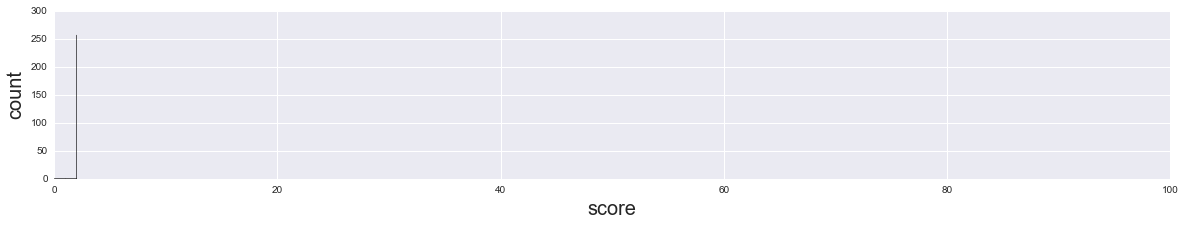

09:37:53: aaa 0.266037300735
09:37:53: found reducer: {'max_value_for_fully_reduce': 2, 'min_value_for_not_reduce': 3, 'reducing_factor': 0.1}

09:37:53: scored___aggr_event__distinct_number_of_dst_machines_ssh_hourly:
09:38:19: median value: 1.0 , max_bad_value_diff: 1
09:38:32: true positives:
09:38:32: Area under histogram: 3621.1
09:38:32: {3.0: 483.85999999999575, 4.0: 577.4099999999997, 5.0: 610.1899999999952, 6.0: 494.8900000000009, 7.0: 343.73999999999984, 8.0: 233.66999999999987, 9.0: 125.63000000000004, 10.0: 119.70000000000005, 11.0: 78.97999999999999, 12.0: 48.910000000000004, 13.0: 34.2, 14.0: 40.129999999999995, 15.0: 21.270000000000003, 16.0: 33.56999999999999, 17.0: 25.27, 18.0: 39.91000000000001, 19.0: 23.51, 20.0: 9.3, 21.0: 15.92, 22.0: 10.129999999999999, 23.0: 8.54, 24.0: 11.25, 25.0: 7.2700000000000005, 26.0: 16.870000000000005, 27.0: 9.530000000000003, 28.0: 4.68, 29.0: 9.11, 30.0: 3.49, 31.0: 6.9, 32.0: 3.77, 33.0: 6.59, 34.0: 2.23, 35.0: 2.0, 36.0: 3.13, 37.0: 

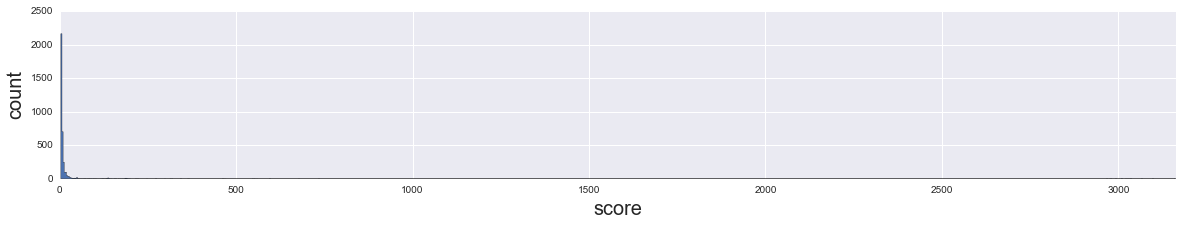

09:38:32: false positives:
09:38:32: Area under histogram: 386.77
09:38:32: {32.0: 7.5, 2.0: 322.70999999999, 3.0: 11.67999999999998, 4.0: 8.53, 5.0: 0.31, 9.0: 0.07, 12.0: 34.760000000000005, 14.0: 0.81, 19.0: 0.33, 156.0: 0.07}


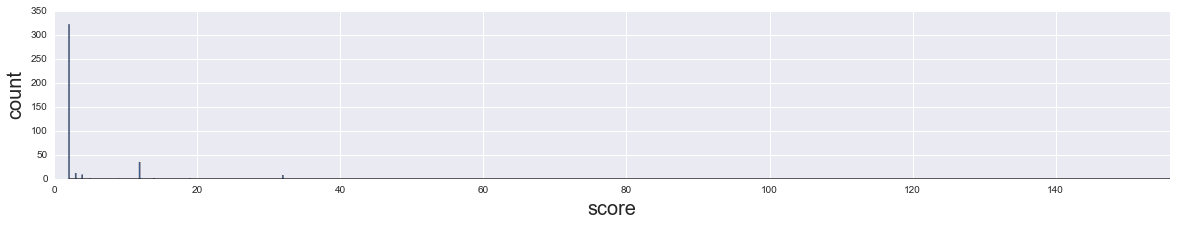

09:38:33: aaa 0.939542860189
09:38:33: found reducer: {'max_value_for_fully_reduce': 2, 'min_value_for_not_reduce': 4, 'reducing_factor': 0.1}

09:38:33: scored___aggr_event__number_of_failed_vpn_events_hourly:
09:38:38: median value: 0.0 , max_bad_value_diff: 1
09:38:40: true positives:
09:38:40: Area under histogram: 1122.99
09:38:40: {2.0: 374.22, 3.0: 252.34999999999974, 4.0: 156.26999999999992, 5.0: 90.90999999999998, 6.0: 58.769999999999996, 7.0: 37.4, 8.0: 33.629999999999995, 9.0: 18.13, 10.0: 12.1, 11.0: 13.829999999999998, 12.0: 10.03, 13.0: 10.04, 14.0: 9.58, 15.0: 3.0100000000000002, 16.0: 8.5, 17.0: 6.620000000000001, 18.0: 1.87, 19.0: 3.0, 20.0: 3.13, 21.0: 0.46, 22.0: 1.63, 25.0: 2.6100000000000003, 24.0: 2.0, 3353.0: 0.67, 26.0: 1.28, 27.0: 2.08, 28.0: 1.07, 29.0: 0.4, 30.0: 0.73, 32.0: 0.46, 39.0: 0.47000000000000003, 41.0: 0.87, 46.0: 0.1, 47.0: 0.13, 55.0: 0.1, 23.0: 1.04, 331.0: 1.0, 81.0: 1.0, 88.0: 0.87, 221.0: 0.13, 3441.0: 0.5}


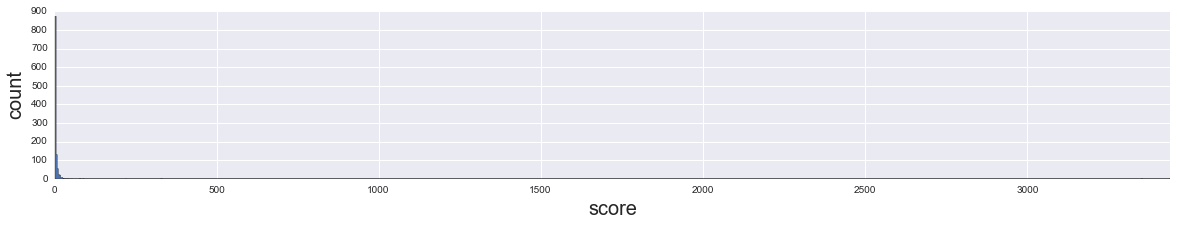

09:38:40: false positives:
09:38:40: Area under histogram: 1056.77
09:38:40: {1.0: 957.8100000000056, 2.0: 98.88999999999989, 5.0: 0.07}


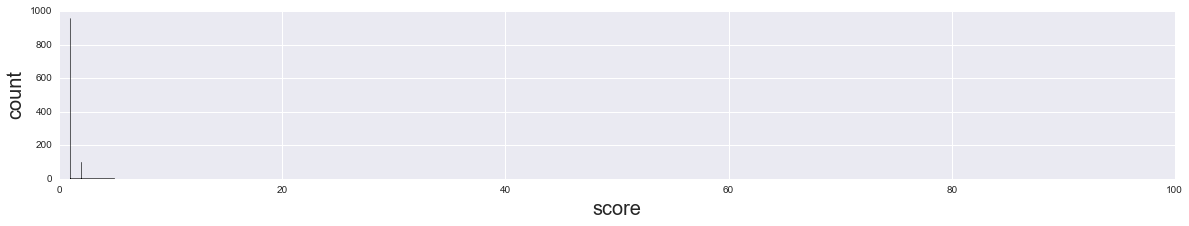

09:38:40: aaa 0.830151835346
09:38:40: found reducer: {'max_value_for_fully_reduce': 2, 'min_value_for_not_reduce': 3, 'reducing_factor': 0.1}

{
    "scored___aggr_event__distinct_number_of_countries_vpn_daily": {
        "max_value_for_fully_reduce": 2, 
        "min_value_for_not_reduce": 3, 
        "reducing_factor": 0.1
    }, 
    "scored___aggr_event__distinct_number_of_countries_vpn_hourly": {
        "max_value_for_fully_reduce": 2, 
        "min_value_for_not_reduce": 3, 
        "reducing_factor": 0.1
    }, 
    "scored___aggr_event__distinct_number_of_dst_machines_kerberos_logins_daily": {
        "max_value_for_fully_reduce": 7, 
        "min_value_for_not_reduce": 9, 
        "reducing_factor": 0.1
    }, 
    "scored___aggr_event__distinct_number_of_dst_machines_ssh_daily": {
        "max_value_for_fully_reduce": 3, 
        "min_value_for_not_reduce": 6, 
        "reducing_factor": 0.1
    }, 
    "scored___aggr_event__distinct_number_of_dst_machines_ssh_hourly": {
  

In [12]:
fs = calc_min_value_for_not_reduce_for_hists(score_to_weight_linear, should_query = False, fs = fs)

In [ ]:
fs = calc_min_value_for_not_reduce_for_hists(score_to_weight_linear, should_query = True, fs = fs)


----------------------------------------------------------------------
--------------------------- Fs reducers  -----------------------------
----------------------------------------------------------------------
15:24:44: querying scored___aggr_event__number_of_successful_ssh_events_hourly...
15:26:09: querying fs of 41714 users...
15:26:09: querying users chunk 1/84 (0%)...
15:28:05: in total queried 186742 fs
15:28:05: querying users chunk 2/84 (1%)...


In [ ]:
print_verbose("The script's run time was", datetime.timedelta(seconds = int(time.time() - start_time)))

In [113]:
print math.log(1)
print math.log(0.9)
print math.log(0.5)

0.0
-0.105360515658
-0.69314718056


In [137]:
PENALTY_IMPORTANCE = 0.02

area = 1. / fs_reduction.calc_reducer_weight('scored___aggr_event__distinct_number_of_dst_machines_kerberos_logins_hourly', {
            'max_value_for_fully_reduce': 10,
            'min_value_for_not_reduce': 13,
            'reducing_factor': 0.5
        }) - 1
print area, math.log(area)

print PENALTY_IMPORTANCE * -1 * (1 - fs_reduction.calc_reducer_weight('scored___aggr_event__distinct_number_of_dst_machines_kerberos_logins_hourly', {
            'max_value_for_fully_reduce': 2,
            'min_value_for_not_reduce': 16,
            'reducing_factor': 0.5
        }))

6.0 1.79175946923
-0.0165217391304


In [41]:
(-math.log(1 - 0.999664841769)) ** 0.5

2.8285875991931198